In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt

In [25]:
# Set the random seed for replicated results
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
# Load data from CSV file
data = pd.read_csv('dataset.csv', header=None)
data = data.values

In [27]:
#plot the data 
plt.plot(data,label = 'x= datapoints \n y= temperature')
plt.legend()
plt.show()

In [28]:
# Reshape the data into a 3D array
data = np.reshape(data, (data.shape[0], data.shape[1], 1))

In [29]:
# Split data into training and testing datasets
train_size = int(len(data) * 0.6)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size,:,:], data[train_size:len(data),:,:]

In [30]:
# Define LSTM autoencoder model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(None, 1)))
model.add(RepeatVector(1))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')


In [31]:
# Train the model and save the history
history = model.fit(train_data, train_data, epochs=50, batch_size=60, validation_data=(test_data, test_data), verbose=1)


Epoch 1/50
160/160 [==============================] - 1s 5ms/step - loss: 1132.0221 - val_loss: 0.0770
Epoch 2/50
160/160 [==============================] - 1s 3ms/step - loss: 0.0266 - val_loss: 0.1520
Epoch 3/50
160/160 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0882
Epoch 4/50
160/160 [==============================] - 1s 3ms/step - loss: 8.9355e-04 - val_loss: 0.0749
Epoch 5/50
160/160 [==============================] - 1s 3ms/step - loss: 2.4264e-04 - val_loss: 0.0676
Epoch 6/50
160/160 [==============================] - 1s 3ms/step - loss: 1.2261e-04 - val_loss: 0.0638
Epoch 7/50
160/160 [==============================] - 1s 4ms/step - loss: 1.0349e-04 - val_loss: 0.0646
Epoch 8/50
160/160 [==============================] - 1s 4ms/step - loss: 1.0177e-04 - val_loss: 0.0625
Epoch 9/50
160/160 [==============================] - 1s 3ms/step - loss: 1.0092e-04 - val_loss: 0.0647
Epoch 10/50
160/160 [==============================] - 1s 3ms/step - loss

In [32]:
# Make predictions on the train dataset
X_train_pred = model.predict(train_data, verbose=1)


300/300 [==============================] - 0s 836us/step


In [33]:
# Calculate MAE loss on the train dataset
train_mae_loss = np.mean(np.abs(X_train_pred - train_data), axis=1)
# Flatten the train_mae_loss array
train_mae_loss = train_mae_loss.flatten()


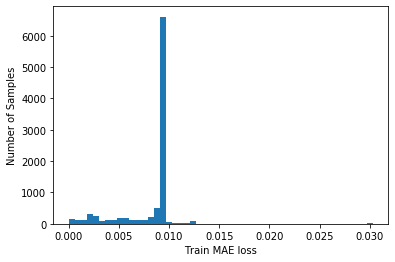

In [34]:
# Visualize MAE loss on the train dataset
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [35]:
# Make predictions on the test dataset
X_test_pred = model.predict(test_data, verbose=1)


200/200 [==============================] - 0s 893us/step


In [36]:
# Calculate MAE loss on the test dataset
test_mae_loss = np.mean(np.abs(X_test_pred - test_data), axis=1)


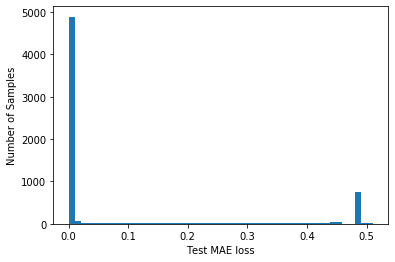

In [37]:
# Visualize MAE loss on the test dataset
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [38]:
# Calculate the reconstruction error and define the threshold for anomaly detection
threshold = 0.01
error = np.mean(np.abs(X_test_pred - test_data), axis=1)


In [39]:
# Create a dataframe of the test dataset and anomaly detection results
df = pd.DataFrame({'data': test_data[:,0,0], 'error': error[:,0]})
df['loss'] = test_mae_loss
df['anomaly'] = df['error'] > threshold

# Set the threshold value for the test data, decided from test MAE histogram
threshold_value = 0.05

# Create a new column named "threshold" and set all values to threshold_value
num_samples = test_data.shape[0]
df['threshold'] = np.full(num_samples, threshold_value)

In [40]:
# Plot the anomaly dataframe and test dataset
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color1 = 'blue'
color2 = 'red'

line1 = ax1.plot(df.index, df['data'], color=color1, label = 'data')
line2 = ax2.plot(df.index, df['loss'], color=color2, label = 'Anomaly')
line3 = ax2.plot(df.index, df['threshold'], color='red', linestyle = 'dotted', label = 'Threshold val')

ax2.set_ylim([-0.1, 1.1])
plt.title('Anomaly Detection Results')
plt.xlabel('Test data')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Anomaly')

ax2.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color2)
ax1.tick_params(axis = 'y', labelcolor = color1)
ax2.tick_params(axis = 'y', labelcolor = color2)

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc = "center right")

plt.show()


In [41]:
df.head()

data     error      loss  anomaly  threshold
0  72.119247  0.009254  0.009254    False       0.05
1  72.118561  0.009254  0.009254    False       0.05
2  72.118225  0.009254  0.009254    False       0.05
3  72.106804  0.009216  0.009216    False       0.05
4  72.119316  0.009262  0.009262    False       0.05

In [42]:
# Initialize variables for anomaly detection
window_size = 100
num_windows = int(len(test_data) / window_size)
consecutive_anomalies = 0

# Check each window of test data for anomalies
for i in range(num_windows):
    start_index = i * window_size
    end_index = start_index + window_size
    
    # Get the anomaly status for this window
    window_anomalies = df['anomaly'][start_index:end_index].values
    
    # Check if any anomalies were detected in this window
    if window_anomalies.sum() == 0:
        print(f"Window {i+1}: Normal Operation")
        consecutive_anomalies = 0
    else:
        print(f"Window {i+1}: Anomaly Detected")
        consecutive_anomalies += 1
        
        # Check if three consecutive windows had anomalies
        if consecutive_anomalies >= 3:
            print("Fault Detected!")
            consecutive_anomalies = 3

Window 1: Normal Operation
Window 2: Normal Operation
Window 3: Normal Operation
Window 4: Normal Operation
Window 5: Anomaly Detected
Window 6: Normal Operation
Window 7: Normal Operation
Window 8: Normal Operation
Window 9: Normal Operation
Window 10: Anomaly Detected
Window 11: Normal Operation
Window 12: Normal Operation
Window 13: Normal Operation
Window 14: Normal Operation
Window 15: Normal Operation
Window 16: Normal Operation
Window 17: Normal Operation
Window 18: Normal Operation
Window 19: Normal Operation
Window 20: Normal Operation
Window 21: Normal Operation
Window 22: Normal Operation
Window 23: Normal Operation
Window 24: Normal Operation
Window 25: Normal Operation
Window 26: Normal Operation
Window 27: Normal Operation
Window 28: Normal Operation
Window 29: Normal Operation
Window 30: Normal Operation
Window 31: Normal Operation
Window 32: Normal Operation
Window 33: Normal Operation
Window 34: Normal Operation
Window 35: Normal Operation
Window 36: Normal Operation
W